# Import modules

In [1]:
import datetime
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tx_fast_hydrology.muskingum import Muskingum, ModelCollection, Connection
from tx_fast_hydrology.simulation import AsyncSimulation
from tx_fast_hydrology.da import KalmanFilter

# Load model collection

In [2]:
# Define model file input path
input_path = '../data/shoal_waller_less_densified_partitioned.json'
# Load model collection from file
model_collection = ModelCollection.from_file(input_path)

Text(0.5, 1.0, 'Sub-models')

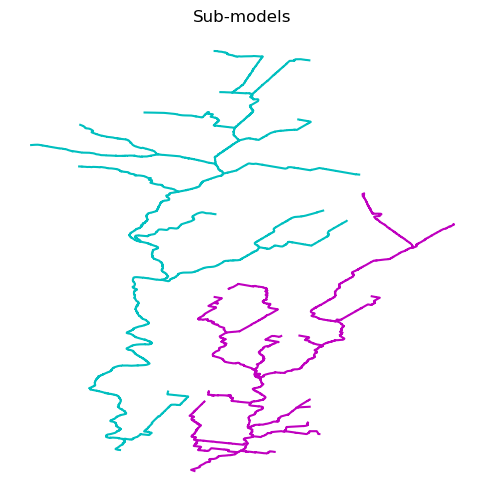

In [3]:
# Plot model collection with sub-models in different colors
fig, ax = plt.subplots(figsize=(6,6))
colors = dict(zip(model_collection.models.keys(), ['c', 'm', 'y', 'k']))
for model_name, model in model_collection.models.items():
    model.plot(ax=ax, c=colors[model_name])
plt.axis('off')
plt.title('Sub-models')

# Create model inputs

### Load NWM forcings

In [4]:
# Define path for NWM forcings
forcing_path = '../data/20240122_event'
# Required NWM variables
nwm_vars = ['qBucket', 'qSfcLatRunoff', 'streamflow']
# Date range to load
date_list = pd.date_range('20240121', '20240124', freq='h', tz='utc')[:-1]

# Loop through HDF5 files and load forcings into memory
streamflows = []
runoffs = []
buckets = []
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='no_data_assimilation__qBucket')
    streamflows.append(streamflow)
    runoffs.append(runoff)
    buckets.append(bucket)
# Concatenate all forcings into single dataframe
streamflow = pd.concat(streamflows)
runoff = pd.concat(runoffs)
bucket = pd.concat(buckets)
# Lateral inflow at each reach is equal to runoff plus bucket recharge
forcing = runoff + bucket

# Ensure no duplicate entries
forcing = forcing.groupby(level=0).mean()
streamflow = streamflow.groupby(level=0).mean()

# Format column types
forcing.columns = forcing.columns.astype(str)
streamflow.columns = forcing.columns.astype(str)

### Set up input columns and dt for assimilating gage data

In [5]:
input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
dt = model_collection.timedelta.seconds

## Gather gage measurements for event period

In [6]:
pd.read_csv('../data/NWPSGages_Shoal_Waller_to_Less_Densified.csv', index_col=0)[['usgs_id','HydroID']].reset_index(drop=True).dropna().reset_index(drop=True)

,usgs_id,HydroID
0,8156800,3688
1,8156675,3621
2,8157540,3588
3,8157560,3705
4,8156910,3647


In [7]:
# Load table of mappings from USGS Gage IDs to Dean's densification IDs
usgs_to_densified_reach_df = pd.read_csv('../data/NWPSGages_Shoal_Waller_to_Less_Densified.csv', index_col=0) 
usgs_to_densified_reach_df = usgs_to_densified_reach_df[['usgs_id','HydroID']].reset_index(drop=True).dropna().reset_index(drop=True)
usgs_to_densified_reach_df['usgs_id'] = usgs_to_densified_reach_df['usgs_id'].astype(int).astype(str)
usgs_to_densified_reach_df['reach_id'] = usgs_to_densified_reach_df['HydroID'].astype(int).astype(str)
# Filter 
usgs_to_densified_reach_df = usgs_to_densified_reach_df[usgs_to_densified_reach_df['reach_id'].isin(input_columns)]

usgs_to_densified_reach = pd.Series(usgs_to_densified_reach_df['reach_id'].values, index=usgs_to_densified_reach_df['usgs_id'].values)

In [8]:
# Load table of USGS gage measurements
measurements = pd.read_hdf('../data/gages.h5', key='usgs') #pd.read_hdf('../data/gages_usgs_20240121_to_20240124.h5', key='usgs')
measurements.columns = measurements.columns.astype(int).astype(str) # 596 gages 2020-2024-7
measurements = measurements[usgs_to_densified_reach.index]
measurements.columns = measurements.columns.map(usgs_to_densified_reach) # change the column to COMID
measurements = measurements.loc[forcing.index[0]:forcing.index[-1]] 
#select the right time period as the forcing
measurements = measurements.dropna(axis=1) # drop gages without data
measurements = measurements.loc[:, ~(measurements == 0.).all(axis=0).values]  # 
# drop gages where all flow are zeros
measurements = measurements.loc[:, ~measurements.columns.duplicated()].copy()
measurements = measurements.resample(f'{dt}s').mean().interpolate().ffill().bfill() 
measurements

,3688,3621,3588,3647
2024-01-21 00:00:00+00:00,0.002029,0.000000,0.284018,0.004248
2024-01-21 00:00:20+00:00,0.002028,0.000000,0.284027,0.004248
2024-01-21 00:00:40+00:00,0.002027,0.000000,0.284037,0.004248
2024-01-21 00:01:00+00:00,0.002025,0.000000,0.284046,0.004248
2024-01-21 00:01:20+00:00,0.002024,0.000000,0.284056,0.004248
...,...,...,...,...
2024-01-23 22:58:40+00:00,0.385424,0.210047,0.553940,0.055585
2024-01-23 22:59:00+00:00,0.385345,0.209886,0.553972,0.055505
2024-01-23 22:59:20+00:00,0.385266,0.209725,0.554003,0.055425
2024-01-23 22:59:40+00:00,0.385188,0.209564,0.554035,0.055345


# Set up Kalman Filter

In [9]:
# Set up Kalman Filtering
for model in model_collection.models.values():
    # Find subset of gages for each sub-model
    model_sites = [reach_id for reach_id in model.reach_ids 
                    if reach_id in measurements.columns]
    if model_sites:
        # Get subset of measurements for sub-model
        basin_measurements = measurements[model_sites]
        # Process noise covariance matrix
        Q_cov = 1. * np.eye(model.n) # how much confindence in the model vs measurements...if the Q_cov is small, we are trust the model
        # Measurement noise covariance matrix
        R_cov = 1. * np.eye(basin_measurements.shape[1])
        # Initial estimate of error covariance matrix
        P_t_init = Q_cov.copy()
        # Create Kalman Filter
        kf = KalmanFilter(model, basin_measurements, Q_cov, R_cov, P_t_init)
        # Bind Kalman Filter to model
        model.bind_callback(kf, key='kf')

# Forecasting

In [10]:
def load_nwm_data(forcing_path, date):
    date_str = date.strftime('%Y%m%d%H')
    streamflow = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__streamflow')
    runoff = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qSfcLatRunoff')
    bucket = pd.read_hdf(f'{forcing_path}/{date_str}.h5', key='short_range__qBucket')


    forcing = runoff + bucket
    return streamflow, forcing

In [25]:
date_list

DatetimeIndex(['2024-01-21 00:00:00+00:00', '2024-01-21 01:00:00+00:00',
               '2024-01-21 02:00:00+00:00', '2024-01-21 03:00:00+00:00',
               '2024-01-21 04:00:00+00:00', '2024-01-21 05:00:00+00:00',
               '2024-01-21 06:00:00+00:00', '2024-01-21 07:00:00+00:00',
               '2024-01-21 08:00:00+00:00', '2024-01-21 09:00:00+00:00',
               '2024-01-21 10:00:00+00:00', '2024-01-21 11:00:00+00:00',
               '2024-01-21 12:00:00+00:00', '2024-01-21 13:00:00+00:00',
               '2024-01-21 14:00:00+00:00', '2024-01-21 15:00:00+00:00',
               '2024-01-21 16:00:00+00:00', '2024-01-21 17:00:00+00:00',
               '2024-01-21 18:00:00+00:00', '2024-01-21 19:00:00+00:00',
               '2024-01-21 20:00:00+00:00', '2024-01-21 21:00:00+00:00',
               '2024-01-21 22:00:00+00:00', '2024-01-21 23:00:00+00:00',
               '2024-01-22 00:00:00+00:00', '2024-01-22 01:00:00+00:00',
               '2024-01-22 02:00:00+00:00', '2024-0

In [11]:
all_outputs_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    model_collection.load_states()
    
    streamflow, forcing = load_nwm_data(forcing_path, date)
    forcing.columns = forcing.columns.astype(str)
    streamflow.columns = forcing.columns.astype(str)
    inputs = forcing

    input_columns = list(itertools.chain.from_iterable([model.reach_ids for model 
                                                    in model_collection.models.values()]))
    input_index = forcing.index.copy()
    inputs = pd.DataFrame(0., index=input_index, columns=input_columns)

    # Fill input table with forcings for each reach
    store = pd.HDFStore('../data/area_fractions_shoalwaller.h5', 'r')
    hdf_keys = store.keys()
    store.close()
    for key in hdf_keys:
        comid = key.split('__')[-1]
        area_ratios = pd.read_hdf(f'../data/area_fractions_shoalwaller.h5', key=key)
        for reach_id in area_ratios.index:
            if comid in forcing.columns:
                runoff_proportion = area_ratios.loc[reach_id].item() * forcing[comid]
                reach_id_str = str(reach_id)
                if reach_id_str in inputs.columns:
                    inputs[reach_id_str] += runoff_proportion

    inputs.columns = inputs.columns.astype(str)
    dt = model_collection.timedelta.seconds
    inputs = inputs.resample(f'{dt}s').mean()
    inputs = inputs.interpolate().bfill().ffill()

    if hasattr(model, 'callbacks') and 'kf' in model.callbacks:
        measurement_timestep = date
        measurements_columns = model.callbacks['kf'].measurements.columns
        model.callbacks['kf'].measurements = basin_measurements.loc[[measurement_timestep], measurements_columns]
    
    for model in model_collection.models.values():
        outlet = model.startnodes[model.startnodes == model.endnodes].item()
        model.set_transmissive_boundary(outlet)

    timedelta = pd.to_timedelta(dt, unit='s')
    for model_name, model in model_collection.models.items():
        model.datetime = inputs.index[0] - pd.to_timedelta('1h')

    simulation = AsyncSimulation(model_collection, inputs)
    outputs = await simulation.simulate()
    all_outputs_da[date_str] = pd.concat([series for series in outputs.values()], axis=1)

In [12]:
date_str

'2024012323'

In [13]:
all_outputs_da[date_str]

,3578,3579,3580,3581,3594,3595,3596,3597,3598,3599,...,3677,3678,3694,3695,3696,3697,3698,3700,3705,3706
2024-01-21 23:00:00+00:00,8.049873e-18,3.490272e-13,3.692005e-10,4.607226e-09,3.526479e-16,1.242319e-14,2.140980e-13,2.166809e-14,6.498664e-13,1.299816e-16,...,-0.005089,0.031921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000010
2024-01-21 23:00:20+00:00,5.318325e-05,3.924333e-04,3.693291e-05,-1.007301e-05,4.751314e-04,-4.407642e-05,3.867927e-04,2.371507e-04,2.444375e-04,2.859823e-04,...,-0.004286,0.028816,0.000237,0.000777,-0.000152,0.000091,0.000024,0.000055,0.001098,0.001098
2024-01-21 23:00:40+00:00,9.075297e-05,8.058693e-04,8.191476e-05,-1.272304e-05,9.176588e-04,-4.314776e-05,7.310758e-04,4.598231e-04,4.926669e-04,5.489382e-04,...,-0.003613,0.026075,0.000460,0.001526,-0.000239,0.000174,0.000056,0.000105,0.002573,0.002573
2024-01-21 23:01:00+00:00,1.172930e-04,1.223074e-03,1.398318e-04,2.186315e-06,1.329819e-03,-3.183054e-06,1.040571e-03,6.689011e-04,7.433142e-04,7.907217e-04,...,-0.003045,0.023649,0.000669,0.002247,-0.000268,0.000249,0.000095,0.000151,0.002626,0.002626
2024-01-21 23:01:20+00:00,1.360414e-04,1.632799e-03,2.142063e-04,4.112043e-05,1.713697e-03,7.045592e-05,1.321887e-03,8.652148e-04,9.951589e-04,1.013038e-03,...,-0.002558,0.021497,0.000866,0.002940,-0.000244,0.000318,0.000139,0.000193,0.001280,0.001280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22 16:58:40+00:00,6.178235e-03,9.882936e-01,3.345176e+00,6.418797e+00,4.063546e-01,5.405099e-01,8.360244e-01,1.579483e-01,4.062357e-01,1.303988e-01,...,0.028894,0.092823,0.027950,0.129680,0.200885,0.010606,0.024969,0.011288,10.150260,10.150260
2024-01-22 16:59:00+00:00,6.103554e-03,9.803094e-01,3.322591e+00,6.379586e+00,4.024763e-01,5.360066e-01,8.292748e-01,1.563204e-01,4.024457e-01,1.289743e-01,...,0.028426,0.091382,0.027356,0.127324,0.198188,0.010403,0.024566,0.011096,10.120625,10.120625
2024-01-22 16:59:20+00:00,6.028874e-03,9.723250e-01,3.300000e+00,6.340345e+00,3.985981e-01,5.315034e-01,8.225251e-01,1.546926e-01,3.986557e-01,1.275497e-01,...,0.027959,0.089942,0.026762,0.124968,0.195491,0.010200,0.024163,0.010904,10.090728,10.090728
2024-01-22 16:59:40+00:00,5.954193e-03,9.643406e-01,3.277402e+00,6.301076e+00,3.947198e-01,5.270001e-01,8.157753e-01,1.530647e-01,3.948656e-01,1.261252e-01,...,0.027491,0.088502,0.026167,0.122613,0.192794,0.009997,0.023760,0.010712,10.060570,10.060570


In [15]:
all_outputs_da 

{'2024012100':                                    3578          3579          3580  \
 2024-01-21 00:00:00+00:00  8.049873e-18 -1.032198e-17  7.751666e-16   
 2024-01-21 00:00:20+00:00  5.633003e-05  4.033831e-04  3.877003e-05   
 2024-01-21 00:00:40+00:00  9.612271e-05  8.296426e-04  8.607921e-05   
 2024-01-21 00:01:00+00:00  1.242331e-04  1.261296e-03  1.472381e-04   
 2024-01-21 00:01:20+00:00  1.440908e-04  1.686831e-03  2.260720e-04   
 ...                                 ...           ...           ...   
 2024-01-21 17:58:40+00:00  1.796767e-04  1.496464e-02  5.001047e-02   
 2024-01-21 17:59:00+00:00  1.796764e-04  1.496242e-02  5.000854e-02   
 2024-01-21 17:59:20+00:00  1.796761e-04  1.496021e-02  5.000661e-02   
 2024-01-21 17:59:40+00:00  1.796758e-04  1.495799e-02  5.000467e-02   
 2024-01-21 18:00:00+00:00  1.796755e-04  1.495577e-02  5.000272e-02   
 
                                    3581          3594          3595  \
 2024-01-21 00:00:00+00:00 -4.311918e-14  2.2936

In [13]:
site = '3701'

site_output_da = {}
for date in date_list:
    date_str = date.strftime('%Y%m%d%H')
    site_output_da[date] = all_outputs_da[date_str][site]

In [15]:
all_outputs_da[date_str][site]

2024-01-21 23:00:00+00:00     0.000003
2024-01-21 23:00:20+00:00     0.000325
2024-01-21 23:00:40+00:00     0.000664
2024-01-21 23:01:00+00:00     0.001018
2024-01-21 23:01:20+00:00     0.001383
                               ...    
2024-01-22 16:58:40+00:00    24.379050
2024-01-22 16:59:00+00:00    24.397466
2024-01-22 16:59:20+00:00    24.415393
2024-01-22 16:59:40+00:00    24.432830
2024-01-22 17:00:00+00:00    24.449772
Name: 3701, Length: 3241, dtype: float64

In [18]:
site_output_da.keys()

dict_keys([Timestamp('2024-01-21 00:00:00+0000', tz='UTC'), Timestamp('2024-01-21 01:00:00+0000', tz='UTC'), Timestamp('2024-01-21 02:00:00+0000', tz='UTC'), Timestamp('2024-01-21 03:00:00+0000', tz='UTC'), Timestamp('2024-01-21 04:00:00+0000', tz='UTC'), Timestamp('2024-01-21 05:00:00+0000', tz='UTC'), Timestamp('2024-01-21 06:00:00+0000', tz='UTC'), Timestamp('2024-01-21 07:00:00+0000', tz='UTC'), Timestamp('2024-01-21 08:00:00+0000', tz='UTC'), Timestamp('2024-01-21 09:00:00+0000', tz='UTC'), Timestamp('2024-01-21 10:00:00+0000', tz='UTC'), Timestamp('2024-01-21 11:00:00+0000', tz='UTC'), Timestamp('2024-01-21 12:00:00+0000', tz='UTC'), Timestamp('2024-01-21 13:00:00+0000', tz='UTC'), Timestamp('2024-01-21 14:00:00+0000', tz='UTC'), Timestamp('2024-01-21 15:00:00+0000', tz='UTC'), Timestamp('2024-01-21 16:00:00+0000', tz='UTC'), Timestamp('2024-01-21 17:00:00+0000', tz='UTC'), Timestamp('2024-01-21 18:00:00+0000', tz='UTC'), Timestamp('2024-01-21 19:00:00+0000', tz='UTC'), Timestamp

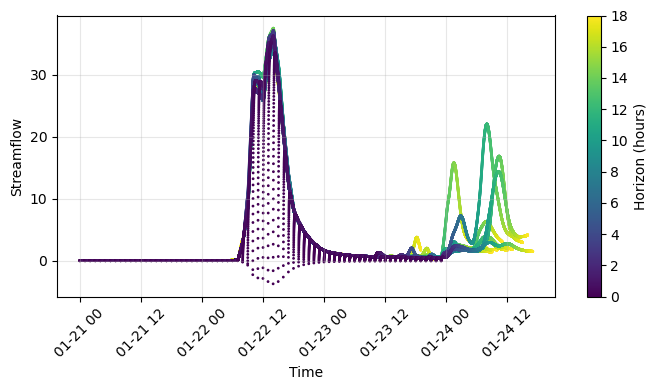

In [14]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)

plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow (cms)')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time-lagged ensemble mean

In [36]:
site_output_da.values()

dict_values([2024-01-21 00:00:00+00:00    0.000053
2024-01-21 00:00:20+00:00    0.000342
2024-01-21 00:00:40+00:00    0.000650
2024-01-21 00:01:00+00:00    0.000957
2024-01-21 00:01:20+00:00    0.001256
                               ...   
2024-01-21 17:58:40+00:00    0.013483
2024-01-21 17:59:00+00:00    0.013483
2024-01-21 17:59:20+00:00    0.013483
2024-01-21 17:59:40+00:00    0.013483
2024-01-21 18:00:00+00:00    0.013483
Name: 3701, Length: 3241, dtype: float64, 2024-01-21 01:00:00+00:00    0.000016
2024-01-21 01:00:20+00:00    0.000335
2024-01-21 01:00:40+00:00    0.000682
2024-01-21 01:01:00+00:00    0.001029
2024-01-21 01:01:20+00:00    0.001368
                               ...   
2024-01-21 18:58:40+00:00    0.013514
2024-01-21 18:59:00+00:00    0.013514
2024-01-21 18:59:20+00:00    0.013514
2024-01-21 18:59:40+00:00    0.013515
2024-01-21 19:00:00+00:00    0.013515
Name: 3701, Length: 3241, dtype: float64, 2024-01-21 02:00:00+00:00    0.000010
2024-01-21 02:00:20+00:00    

In [15]:
da_spreads = {}
da_spread = pd.concat((value for value in site_output_da.values()), axis=1)
da_spreads = da_spread

In [95]:
da_spreads 

,3701,3701,3701,3701,3701,3701,3701,3701,3701,3701,...,3701,3701,3701,3701,3701,3701,3701,3701,3701,3701
2024-01-21 00:00:00+00:00,0.000053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-21 00:00:20+00:00,0.000342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-21 00:00:40+00:00,0.000650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-21 00:01:00+00:00,0.000957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-21 00:01:20+00:00,0.001256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22 16:58:40+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.379050
2024-01-22 16:59:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.397466
2024-01-22 16:59:20+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.415393
2024-01-22 16:59:40+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.432830


In [22]:
da_spreads.iloc[:,0].dropna()[:-6]

2024-01-21 00:00:00+00:00    0.000053
2024-01-21 00:00:20+00:00    0.000342
2024-01-21 00:00:40+00:00    0.000650
2024-01-21 00:01:00+00:00    0.000957
2024-01-21 00:01:20+00:00    0.001256
                               ...   
2024-01-21 17:56:40+00:00    0.014467
2024-01-21 17:57:00+00:00    0.014467
2024-01-21 17:57:20+00:00    0.014467
2024-01-21 17:57:40+00:00    0.014467
2024-01-21 17:58:00+00:00    0.014467
Freq: 20s, Name: 3701, Length: 3235, dtype: float64

In [16]:
def mean_first_12_hours(row): # 6 hours
    valid_values = row.dropna()[:-6]#[-12:-2]#[-19:-12] 3240 -6 correspond to forecasting 12 hours ahead
    return valid_values.mean()

In [17]:
timelagged_da = da_spreads.apply(mean_first_12_hours, axis=1) # drop nan along columns

In [24]:
timelagged_da.dropna()

2024-01-21 06:00:00+00:00    0.014451
2024-01-21 06:00:20+00:00    0.014451
2024-01-21 06:00:40+00:00    0.014451
2024-01-21 06:01:00+00:00    0.014450
2024-01-21 06:01:20+00:00    0.014450
                               ...   
2024-01-24 10:58:40+00:00    3.059138
2024-01-24 10:59:00+00:00    3.055035
2024-01-24 10:59:20+00:00    3.050929
2024-01-24 10:59:40+00:00    3.046820
2024-01-24 11:00:00+00:00    3.042707
Freq: 20s, Length: 13861, dtype: float64

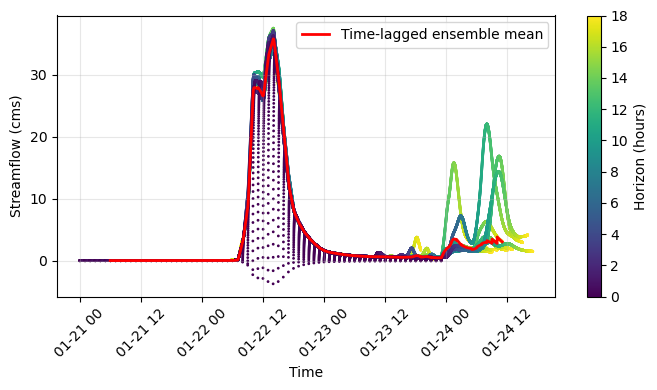

In [28]:
fig, ax = plt.subplots(figsize=(7, 4))

max_horizon = 0
for forecast_time, forecast_series in site_output_da.items():
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    max_horizon = max(max_horizon, max(horizons))

all_target_times = []
all_values = []
all_horizons = []

for forecast_time, forecast_series in list(site_output_da.items()):
    horizons = [(target_time - forecast_time).total_seconds() / 3600 
               for target_time in forecast_series.index]
    
    all_target_times.extend(forecast_series.index)
    all_values.extend(forecast_series.values)
    all_horizons.extend(horizons)

scatter = ax.scatter(all_target_times, all_values, 
                    c=all_horizons, cmap='viridis', s=1, alpha=1,
                    vmin=0, vmax=max_horizon)
plt.plot(timelagged_da.index, timelagged_da.values, color='red', linewidth=2, label='Time-lagged ensemble mean')
plt.colorbar(scatter, ax=ax, label='Horizon (hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Streamflow (cms)')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()